<a href="https://colab.research.google.com/github/lynilla/BangkitPlantPathology/blob/master/BaselineVGG16_image_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6


In [0]:
import os
os.environ['KAGGLE_USERNAME']="stellalindacyrilla"
os.environ['KAGGLE_KEY']="d2e5f971338577bea0ac7608b2d38886"

In [0]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip plant-pathology-2020-fgvc7.zip

Archive:  plant-pathology-2020-fgvc7.zip
replace images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [0]:
submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Images

Healthy Leaves

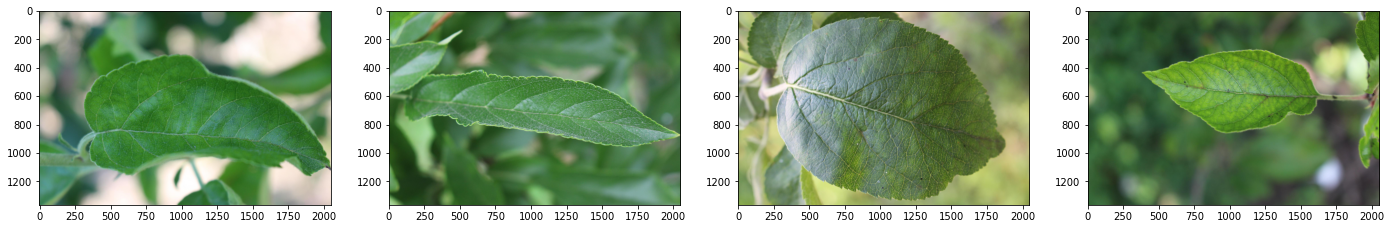

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

healthyImageIDList = train[train['healthy']==1]
img_ids = ['./images/'+i+'.jpg' for i in healthyImageIDList['image_id']]

plt.figure(figsize=(24, 5))

for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img) # read image
    plt.imshow(image)

Leaves with Multiple Disease

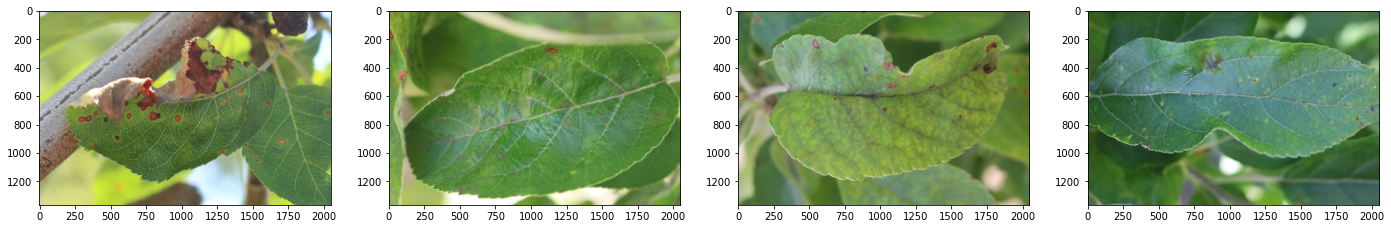

In [0]:
MDLeavesID = train[train['multiple_diseases']==1]
img_ids = ['./images/'+i+'.jpg' for i in MDLeavesID['image_id']]

plt.figure(figsize=(24, 5))

for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img)
    plt.imshow(image)

Leaves with Rust

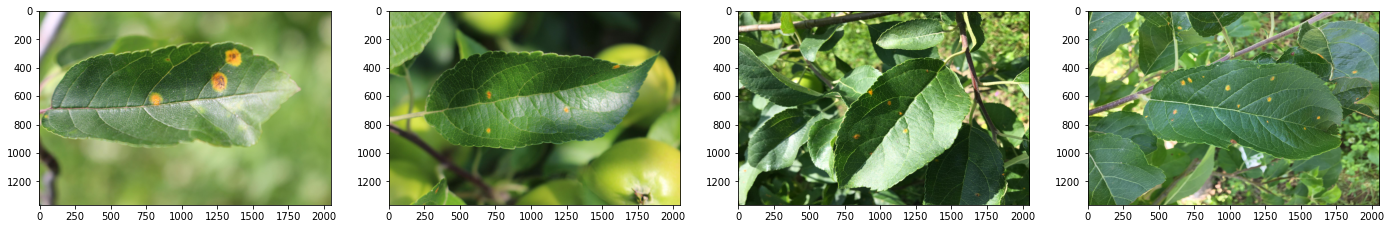

In [0]:
rustLeavesID = train[train['rust']==1]
img_ids = ['./images/'+i+'.jpg' for i in rustLeavesID['image_id']]

plt.figure(figsize=(24, 5))

for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img)
    plt.imshow(image)

Leaves with Scab

1
2
3
4


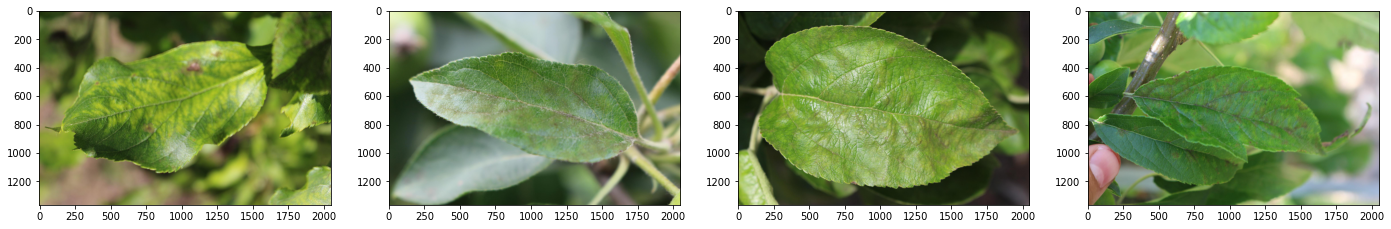

In [0]:
scabLeavesID = train[train['scab']==1]
img_ids = ['./images/'+i+'.jpg' for i in scabLeavesID['image_id']]

plt.figure(figsize=(24, 5))

for ind, img in enumerate(img_ids[:4]):
    plt.subplot(1,4,ind+1)
    image = mpimg.imread(img)
    plt.imshow(image)

In [0]:
test.sample(5)

,image_id
927,Test_927
653,Test_653
35,Test_35
253,Test_253
417,Test_417


In [0]:
submission.sample(5)

,image_id,healthy,multiple_diseases,rust,scab
482,Test_482,0.25,0.25,0.25,0.25
992,Test_992,0.25,0.25,0.25,0.25
839,Test_839,0.25,0.25,0.25,0.25
234,Test_234,0.25,0.25,0.25,0.25
1803,Test_1803,0.25,0.25,0.25,0.25


In [0]:
!ls

images				sample_data	       test.csv
plant-pathology-2020-fgvc7.zip	sample_submission.csv  train.csv


In [0]:
train_img = []
path = "./images"
for im in tqdm(train['image_id']):
  im = im+".jpg"
  fnpath = os.path.join(path,im)
  img = cv2.imread(fnpath)
  img = cv2.resize(img,(224,224))
  img = img.astype('float32')
  train_img.append(img)

100%|██████████| 1821/1821 [01:09<00:00, 26.33it/s]


In [0]:
test_img = []
path = "./images"
for im in tqdm(test['image_id']):
  im = im+".jpg"
  fnpath = os.path.join(path,im)
  img = cv2.imread(fnpath)
  img = cv2.resize(img,(224,224))
  img = img.astype('float32')
  test_img.append(img)

100%|██████████| 1821/1821 [01:06<00:00, 27.57it/s]


In [0]:
train_label = train.iloc[:,1:]
train_img = np.array(train_img)
test_img = np.array(test_img)

In [0]:
print(train_img.shape)
print(train_label.shape)
print(test_img.shape)

(1821, 224, 224, 3)
(1821, 4)
(1821, 224, 224, 3)


Creating Data generator

In [0]:
import tensorflow as tf

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True,
        )
        
datagen.fit(train_img)

In [0]:
base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')
base.trainable = False
model = tf.keras.models.Sequential()
model.add(base)
model.add(tf.keras.layers.Dense(100, 'relu'))
model.add(tf.keras.layers.Dense(4, 'softmax'))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                         factor = 0.1,
                                         patience = 2,
                                         cooldown = 0,
                                         min_lr = 0.00001,
                                         verbose = 1)

callbacks = [reduce_lr]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
training = model.fit(datagen.flow(train_img,train_label), batch_size=32, epochs=20, callbacks=callbacks, steps_per_epoch=200)
#model.fit_generator(datagen.flow(train_img, train_label, batch_size=32), epochs=20, callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 93s 465ms/step - loss: 0.9221 - accuracy: 0.6766 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 90s 450ms/step - loss: 0.5979 - accuracy: 0.7761 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 90s 451ms/step - loss: 0.5247 - accuracy: 0.8122 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 90s 449ms/step - loss: 0.4748 - accuracy: 0.8273 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 89s 444ms/step - loss: 0.4351 - accuracy: 0.8368 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 89s 444ms/step - loss: 0.3974 - accuracy: 0.8555 - lr: 0.0010
Epoch 7/20
200/200 [==============================] - 88s 441ms/step - loss: 0.3760 - accuracy: 0.8584 - lr: 0.0010
Epoch 8/20
200/200 [==============================] - 88s 439ms/step - loss: 0.3428 - accuracy: 0.8735 - lr: 0.0010
Epoch 9/20
200/200 [==============================] - 89s 445ms/step - l

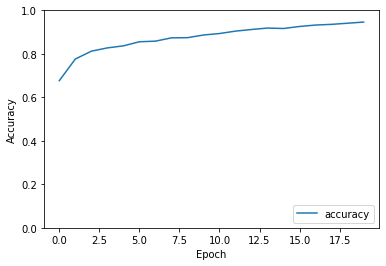

In [0]:
plt.plot(training.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [0]:
y_pred = model.predict(test_img)
submission.loc[:,'healthy':'scab'] = y_pred

In [0]:
print(submission.head())
submission.to_csv('submission.csv', index=False)

  image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.009040       9.728740e-07  9.870628e-01  3.896057e-03
1   Test_1  0.986794       6.356184e-09  8.670693e-06  1.319694e-02
2   Test_2  0.000285       6.346924e-06  1.561345e-01  8.435743e-01
3   Test_3  1.000000       4.391513e-10  2.638552e-07  3.821095e-09
4   Test_4  0.062143       3.311028e-10  9.378377e-01  1.908369e-05


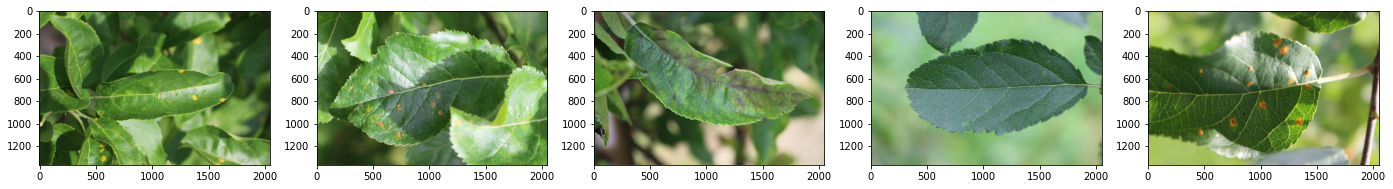

In [0]:
#show the first five test images

plt.figure(figsize=(24, 5))
for i in range(5):
  imgid = submission['image_id'][i]
  plt.subplot(1,5,i+1)
  image = mpimg.imread('./images/'+imgid+'.jpg')
  plt.imshow(image)

In [0]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f submission.csv -m "LB Sub"

100% 165k/165k [00:03<00:00, 52.8kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

Kaggle submission score: 0.781